## PEAK - Proofreader Evaluation Analysis toolKit


###  AGENTS Cohort: Scalability & Analysis Team


Overview of Process Pipeline
1. Kernel Density estimation using gaussian kernel and variable smoothness coefficient h 
2. Construct prior scores using CDF computation and 
3. Construct Likelihood estimation using 3 attributes (given new data)
4. Develop a final posterior score

In [1]:
# import relevant packages
import scipy.stats as stats
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


### Step 1: KDE fitting and Prior Score estimation

1. Define $m \in [0,1] $ as the prior score of a human proofreader. This is directly determined from $Y \in [0,1]$, which is defined as the proportion of proofreading tasks that a proofreader gets correct (based expert ground truth data). 
2. The distribution of $Y \sim f(y_{i})$ where ${i}$ denotes a particular human proofreader: $ 0 <= i <= n$ for n number of total proofreaders. 
3. Estimate $f(y_{i})$. Given the high uncertainty around predictions for parameters of a distribution, a nonparametric technique will be deployed.

    Deploy Kernel Density Estimation (KDE) on proofreader accuracy values from historical tasks completed
        - with hyperparameter Bandwidth $h$  i.e. smoothing coefficient 

   
 >$\displaystyle \mathrm{KDE}(x) = \frac{1}{n}\sum_i K_h(x\!-\!x_i) = \frac{1}{nh}\sum_i K\left(\frac{x\!-\!x_i}{h}\right)$
   
    - Can use different K  kernel functions
        - E.g., Uniform, Triangular, Gauss, Epanechnikov
    - For this model, a Gaussian kernel will be deployed.

4. Compute the cdf (with a fitted value) to generate prior scores: >$\displaystyle \pi(x_{i}) = P(Y < y_{i}) $
- From data $D$ we infer the parameters $\theta$ of model where $\theta$ are our estimates for the 'score' of each human proofreader

>$\displaystyle p(\theta) = \frac{\pi(\theta)\,{\cal{}L}(\theta)}{\int \pi(\theta)\,{\cal{}L}(\theta)\ d\theta }$



In [5]:
def kde_pdf(data_vector, h):
    '''
    Goal: Fit a KDE on the distribution of given data accross all human proofreaders
    Parameters:
        data_vector: input transposed data vector (ex. average accuracy rate for each proofreader, avg duration for a task)
        h: Bandwidth h
    Return:
        kde_estimation plot
        Prior score: [0,1]
    '''
    normalized = (1/(len(data_vector))*h)
    
    sum = 0

    # define support of the cont rv (estimation based on lower and upper bound thresholds)
    # NOTE: our support will be (0,1) given our input data is accuracy and prior estimations will be of the same range of value
    x = np.arange(0,max(data_vector) + 0.2, 0.001)
    
    for i in range(len(data_vector)):
        u = (x-data_vector[i])/h
        sum += stats.norm.pdf(u, loc = 0, scale = 1)

    result = normalized * sum


    # note to compute the cdf we will take input value and 

        # FINISH THIS PART LATER !!!!!

    return result

Text(0, 0.5, 'Probability')

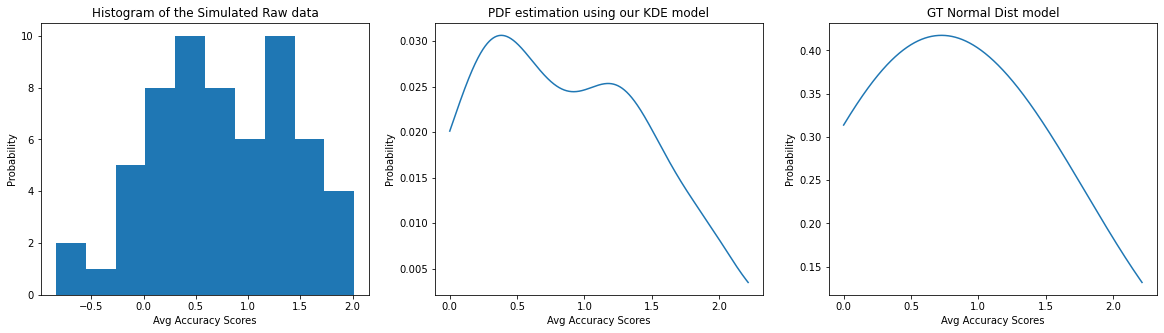

In [6]:
# Generate dummy data to check if the above model works 
np.random.seed(123)
sim_data = stats.norm(loc=0.7, scale=0.55).rvs(60) 
# this 60 simulated points to represent the approx number of proofreaders where the 
# avg accuracy score is simualted to be approx normal with mean=0.7 and std = 0.3


# test and simulate the model against the built in scipy KDE package 
x = np.arange(0,max(sim_data) + 0.2, 0.001)

# ground truth model with default fit of h = 1
kde_package = stats.gaussian_kde(sim_data,1)
pdf_scores_package = kde_package.evaluate(x)

# our model with estimated h as h = 0.654
pdf_scores_model = kde_pdf(sim_data,0.235)

# plot the pdf 
fig_1 = plt.figure(figsize = (20,5), facecolor='w',edgecolor='k')

plt.subplot(131)
plt.title('Histogram of the Simulated Raw data')
plt.hist(sim_data)
plt.xlabel('Avg Accuracy Scores')
plt.ylabel('Probability')

plt.subplot(132)
plt.title('PDF estimation using our KDE model')
plt.plot(x,pdf_scores_model)
plt.xlabel('Avg Accuracy Scores')
plt.ylabel('Probability')

plt.subplot(133)
plt.title('GT Normal Dist model')
plt.plot(x,pdf_scores_package)
plt.xlabel('Avg Accuracy Scores')
plt.ylabel('Probability')

### Step 2: Likelihood Function Estimation

1. Consider 3 attributes given new data (new batch of completed proofreading tasks):
Define $L$ as the number of new proofreading tasks completed

For each proofreader i, we construct the following metrics for our likelihood:

a. S_{avg} = [Accuracy Score among L tasks]

b. T_{avg} = [Time for task completeion among L tasks]

c. D_{avg} = [Difficulty of tasks among L tasks]

The importance of computing the inverse function for time and difficulty ratings. 1/T and 1/D will produce a monotone decreasing function as t, d --> $\inf$

Output the following data vectors:

--> $S_{f} = [S_{1}, S_{2}, ..., S_{n}]$

--> $1/T_{f} = [1/T_{1}, 1/T_{2}, ..., 1/T_{n}]   $

--> $1/D_{f} = [1/D_{1}, 1/D_{2}, ..., 1/D_{n}] $

2. Construct the multivariate distribution of the 3 attributes from above.

$  \phi(b_{i}) = (\frac{1}{2 \pi})^{\frac{p}{2}} |\Sigma|^{\frac{-1}{2}}  \exp(\frac{-1}{2} (\overrightarrow{x} - \overrightarrow{\mu}) |\Sigma|^{-1} (\overrightarrow{x} - \overrightarrow{\mu})  )$ = Multivariate_normal $ (\overrightarrow{\mu}, \overrightarrow{\sigma})$


In [60]:
# custom multivariate normal distribution
def mvndist(x, u, cov):
    """
    The density function of multivariate normal distribution.

    Parameters
    ---------------
    x: ndarray(float, dim=3)
        random vector, N by 1
    μ: ndarray(float, dim=3)
        the mean of x, N by 1
    cov: ndarray(float, dim=3 x 3)
        the covariance matrix of x, N by 1
    """

    N = 3

    temp1 = np.linalg.det(cov) ** (-1/2)
    temp2 = np.exp(-.5 * (x - u).T @ np.linalg.inv(cov) @ (x - u))

    return (2 * np.pi) ** (-N/2) * temp1 * temp2


In [3]:
def likelihood_estimates(x_i, att1, att2, att3):
    '''
    Goal: output the probablistic values of the likelihood function
    Parameters: 
        Linear data vectors for each attribute: S, 1/T, 1/D
        X_i: a single data vector / data point 

    Return:
        likelihood function 

    '''

    # extract a mean vector of the 3 attributes

    acc_mean = np.mean(att1) # S
    time_mean = np.mean(att2) # 1/T
    diff_mean = np.mean(att3) # 1/D

    # μ (mean vector of 3 attributes)
    attr_mean = np.array([acc_mean, time_mean, diff_mean])

    # extract a covariance matrix of the 3 attributes (accuracy)
    data = np.array([att1, att2, att3])

    # should we transpose so each row represnts the data for a single proofreader?
    # data = data.transpose()  

    #cov_matrix = np.cov(data, bias=True)
    #x = np.vstack([att1, att2, att3])
    cov_matrix = np.cov(data)

    # generate a multivariate distribution (pass in data? or the individual x_i vector)
    
    # use .pdf?
    #multivar_dist = multivariate_normal.pdf(data, mean=attr_mean, cov=cov_matrix)
    multivar_dist = multivariate_normal(mean=attr_mean, cov=cov_matrix)

    # extract the cdf of the multivariate distribution at an individual data vector ([att1_i, att2_i, att3_i])
    cdf_xi = multivar_dist.cdf(x_i)

    lk_estimate = cdf_xi

    return lk_estimate


# for each proofreader data point, we compute the likelihood estimation value and generate a data vector of estimates


In [4]:
# accuracies - 100 points uniform distribution
accuracies = np.random.uniform(size=100)

times = np.random.rand(100)

difficulties = np.random.rand(100)

# ith proofreader, just selected 40
x_i = 40

acc_mean = np.mean(accuracies)  # S
time_mean = np.mean(times)  # 1/T
diff_mean = np.mean(difficulties)  # 1/D

# μ (mean vector of 3 attributes)
attr_mean = np.array([acc_mean, time_mean, diff_mean])

print(attr_mean)

# extract a covariance matrix of the 3 attributes (accuracy)
data = np.array([accuracies, times, difficulties])
print(data)

#print(likelihood_estimates(x_i, accuracies, times, difficulties))
cov_matrix = np.cov(data)

#multivar_dist = mvndist(data, attr_mean, cov_matrix)

x_i = np.array([.8, .4, .5])

likelihood_estimates(x_i, accuracies, 1/times, 1/difficulties)



[0.49802464 0.53488955 0.46585143]
[[2.57107983e-01 1.57513409e-01 8.14235923e-01 3.37063353e-01
  7.04230247e-01 2.95229858e-01 2.72144105e-01 5.41300801e-01
  3.10557955e-01 9.36317520e-01 8.32483761e-01 1.73951219e-01
  9.21972160e-01 5.49233187e-01 8.46704722e-01 4.88124966e-01
  4.48599172e-01 7.86668325e-01 3.01849647e-02 9.99627594e-01
  6.20844872e-01 9.76361058e-01 4.61381257e-01 9.18542621e-01
  9.92668170e-01 4.80093072e-01 3.09863420e-01 2.99119250e-01
  7.38408183e-01 5.43455453e-01 2.67510174e-01 8.39005506e-01
  7.61555143e-01 6.53256203e-01 7.19045843e-01 4.66472508e-01
  1.63768689e-01 5.43949676e-01 5.27628919e-01 4.37362280e-01
  6.67385892e-02 3.84147491e-01 8.93718580e-01 2.48972247e-01
  7.64384956e-01 1.72591639e-01 3.05735261e-01 6.32093306e-02
  3.86064675e-01 1.58883665e-01 5.48392442e-01 3.98066627e-01
  4.71294991e-01 7.20081858e-01 5.57422022e-01 4.41104903e-01
  1.44559813e-01 2.25259000e-02 3.03086619e-01 2.68878958e-01
  6.54618500e-02 4.69129236e-01 5.5

0.14546516366250237

In [59]:
# PRACTICE FOR TRAVIS --> DON'T MIND THIS

# Prepare your data
x = np.linspace(-10, 10, 500)
y = np.linspace(-10, 10, 500)
X, Y = np.meshgrid(x, y)

# Get the multivariate normal distribution
mu_x = np.mean(x)
sigma_x = np.std(x)
mu_y = np.mean(y)
sigma_y = np.std(y)
rv = multivariate_normal([mu_x, mu_y], [[sigma_x, 0], [0, sigma_y]])

# Get the probability density
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
pd = rv.pdf(pos)


### Step 3: Computing Posterior Scores

Define W as the final score vector: $W = [w_{1},w_{2},...,w_{n}]$ where n ~ number of proofreaders. $W \in  R^{n}$

$W_{i}$ = prior score x likelihood estimation $= m_{i} * \phi(b_{i}) * \frac{1}{c} $, where $c \in R$ (normalization constant)



In [ ]:
# what is the normalization constant going to be???

# W is calculated using prior from Krutals KDE, and the likelihood produced from Travis's function  

# make a function with two inputs as parameter (prior score, likelihood)
# prior score - vector 
# likelihood - vector 

# c = sum of products for all proofreaders 


'''
For each proofreader i: do the following:
    1. Gets it likelihood probability(from the function above)
    2.get its prior score
    3. Multiply those two quantities
    4. Store this product into a data vector

Then sum that vector
Divide each element in that vector by the sum
Return this(this is posterior score for each proofreader)
'''


In [ ]:
def posterior_score(prior, likelihood):
    '''
    Goal: compute posterior score of each proofreader
    Parameters:
        pior: vector of prior scores ?
        likelihood: vector of likelihood scores? 

    Return:
        posterior_score

    '''

    # element wise multiplication of the prior and likelhood, assumming parameters are linear data vectors
    posterior = np.multiply(prior, likelihood)

    # sum vector
    posterior_sum = np.sum(posterior)

    # divide each element in the vector by the sum
    posterior_score = posterior / posterior_sum 

    return posterior_score
